![Featured Image - work by Ryan Bell](https://i.imgur.com/Db6ErgU.png)

**1.0: Dependencies & Configuration**

In [1]:
import os, random, gc, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
import keras_preprocessing.image
import tensorflow.keras.backend as k
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Input, AvgPool2D, Conv2D
from tensorflow.keras.layers import multiply, concatenate, Lambda, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
from PIL import Image
from google.colab import drive

# Configuration
%matplotlib inline

is_pretrained = True
keep_training = True # Adam -> SGD
batch_size = 39
width = 360
height = 270
learning_rate = 1e-4
proj_dir = './gdrive/My Drive/Colab Notebooks/mmwml_w4_xray_pneumonia_detector'

# Google Drive
drive.mount('/content/gdrive')

print('Tensorflow version: {}'.format(tf.__version__))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Tensorflow version: 1.14.0


In [0]:
# Original Dataset from https://data.mendeley.com/datasets/rscbjbr9sj/2

xray_path = '{}/ChestXRay2017.zip'.format(proj_dir).replace(' ', '\\ ')
!unzip -q $xray_path

**1.1: Data Imports**    
We have 5,232 images in our training set and 624 images in our validation set. There are more pneumonia X-Ray images than normal images. These images are varied in size and canvas orientation.

To increase the robustness of our model, we'll add random jitter to the image using ImageDataGenerator's sheer and zoom controls.

In [3]:
def dir_file_count(directory):
  total_files = 0
  for root, dirs, files in os.walk(".", topdown=False):
    total_files += len(list(filter(lambda x: x.endswith('.jpeg'), files)))
  return total_files

def xray_process(im):
  # X-Rays are negative images. Imagenet was trained on normal images.
  im = 255. - im

  # Imagenet tensorflow samples are scaled between -1 (black) and 1 (white)
  # https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  im /= 255.
  im -= .5
  im *= 2.
  return im

target_size = (height, width)
class_mode = 'categorical'
training_dir = './chest_xray/train'
testing_dir = './chest_xray/test'

train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=xray_process)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    interpolation='lanczos',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

Found 5232 images belonging to 2 classes.


We'll usee a separate generator for the test set which avoids the randomized jitter and horizontal flipping.

In [4]:
test_datagen = ImageDataGenerator(
                                  fill_mode='nearest',
                                  preprocessing_function=xray_process)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    interpolation='lanczos',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=False)

Found 624 images belonging to 2 classes.


In [5]:
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced',
                                                             np.unique(y), y)
    return class_weight_current

class_w = get_weight(train_generator.classes)
print(class_w)

[1.93921423 0.6737059 ]


In [0]:
def get_image_set(image_set, image_type):
  def get_image_path(path_pre, image_name):
    return '{}/{}/{}/{}'.format(path_pre, image_set, image_type, image_name)

  path_pre = './chest_xray'
  image_list = os.listdir('{}/{}/{}'.format(path_pre, image_set, image_type))
  image_list = list(map(lambda x: get_image_path(path_pre, x), image_list))

  # Ignore .DS_Store files
  image_list = list(filter(lambda x: x.endswith('.jpeg'), image_list))
  return image_list

tr_normal = get_image_set('train', 'NORMAL')
tr_pneumonia = get_image_set('train', 'PNEUMONIA')

te_normal = get_image_set('test', 'NORMAL')
te_pneumonia = get_image_set('test', 'PNEUMONIA')

images_normal = tr_normal + te_normal
images_pneumonia = tr_pneumonia + te_pneumonia
images_pneumonia_bacterial = [img for img in images_pneumonia
                              if img.split('/')[-1].split('_')[1] == 'bacteria']
images_pneumonia_viral = [img for img in images_pneumonia
                          if img.split('/')[-1].split('_')[1] == 'virus']

images_full = images_normal + images_pneumonia
images_test = te_normal + te_pneumonia

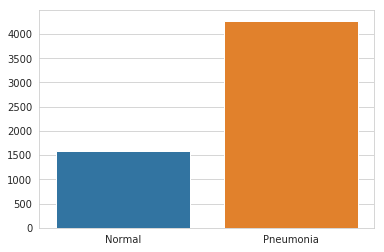

In [7]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal', 'Pneumonia'],
            y=[len(images_normal),
               len(images_pneumonia)])

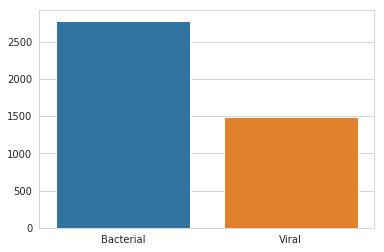

In [8]:
sns.set_style('whitegrid')
sns.barplot(x=['Bacterial', 'Viral'],
            y=[len(images_pneumonia_bacterial),
               len(images_pneumonia_viral)])

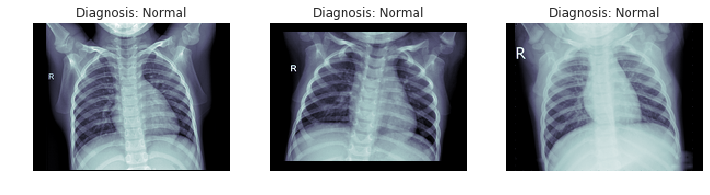

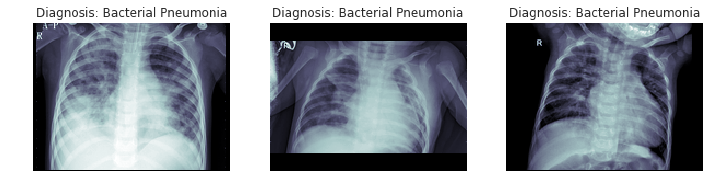

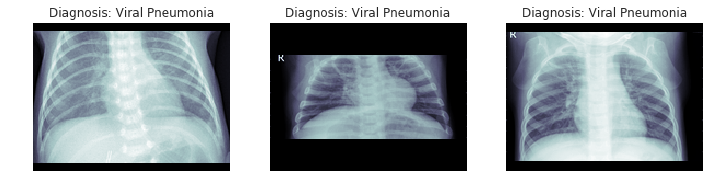

In [9]:
def get_image(path):
  return cv2.imread(path, 0)

def get_resized_image(path, width, height):
  im = Image.fromarray(get_image(path))
  im_w, im_h = im.size

  # Proportionally scale to be contained within canvas bounds.
  if im_w > width:
    im_h = int(width/im_w * im_h)
    im_w = width
  if im_h > height:
    im_w = int(height/im_h * im_w)
    im_h = height

  if [im_w, im_h] != list(im.size):
    im.thumbnail((im_w, im_h), Image.ANTIALIAS)

  # Return the image over a black background.    
  im_resized = Image.new('RGB', (width, height), (0, 0, 0))
  offset = ((width - im.size[0]) // 2,
            (height - im.size[1]) // 2)
  im_resized.paste(im, offset)

  return np.array(im_resized)

def plot_sample_xrays(image_set, image_label,
                      width=width//2, height=height//2,
                      rows=1, cols=3,
                      size_w=4, size_h=3):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  for idx in range(rows*cols):
    i = random.randint(0, len(image_set))
    im = get_resized_image(image_set[i], width, height)[:, :, 0]
    ax[idx%cols].imshow(im, cmap='bone')
    ax[idx%cols].axis('off')
    ax[idx%cols].set_title('Diagnosis: {}'.format(image_label))
  plt.show()

plot_sample_xrays(images_normal, 'Normal')
plot_sample_xrays(images_pneumonia_bacterial, 'Bacterial Pneumonia')
plot_sample_xrays(images_pneumonia_viral, 'Viral Pneumonia')

**3.0: Model Architecture**    
We'll convert the weights on VGG16 to a greyscale average. Then, we'll run VGG16 + VGG19 in parallel through fully-connected Dense layers with Dropout to reduce overfitting.

In [0]:
# Pre-training on Grayscale ImageNet Improves Medical Image Classification
# https://link.springer.com/chapter/10.1007/978-3-030-11024-6_37
# (src) https://github.com/RohitSaha/VGG_Imagenet_Weights_GrayScale_Images/blob/master/convert_vgg_grayscale.py

def VGG16_bw():
	model = VGG16(weights='imagenet', include_top=False)
	block1_conv1 = model.get_layer('block1_conv1').get_weights()
	weights, biases = block1_conv1

	weights = np.transpose(weights, (3, 2, 0, 1))
	kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape
	grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

	for i in range(kernel_out_channels):
		get_kernel = weights[i, :, :, :]
		temp_kernel = np.zeros((3, 3))
		in_channels, in_rows, in_columns = get_kernel.shape

		for in_row in range(in_rows):
			for in_col in range(in_columns):
				feature_red = get_kernel[0, in_row, in_col]
				feature_green = get_kernel[1, in_row, in_col]
				feature_blue = get_kernel[2, in_row, in_col]

				total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)
				temp_kernel[in_row, in_col] = total

		temp_kernel = np.expand_dims(temp_kernel, axis=0)
		grayscale_weights[i, :, :, :] = temp_kernel

	grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0))
	new_block1_conv1 = [grayscale_weights, biases]
	vgg16_weights = {}
	for layer in model.layers[2:]:
		if "conv" in layer.name:
			vgg16_weights["vgg16bw_" + layer.name] = model.get_layer(layer.name).get_weights()

	del model

	# Custom build VGG16

	vgg16_bw_input = Input(shape=(height, width, 1), name='vgg16bw_input')
	# Block 1
	x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(height, width, 1), data_format="channels_last", name='vgg16bw_block1_conv1')(vgg16_bw_input)
	x = Conv2D(64, (3, 3), activation='relu', padding='same', name='vgg16bw_block1_conv2')(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block1_pool')(x)

	# Block 2
	x = Conv2D(128, (3, 3), activation='relu', padding='same', name='vgg16bw_block2_conv1')(x)
	x = Conv2D(128, (3, 3), activation='relu', padding='same', name='vgg16bw_block2_conv2')(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block2_pool')(x)

	# Block 3
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv1')(x)
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv2')(x)
	x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv3')(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block3_pool')(x)

	# Block 4
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv1')(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv2')(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv3')(x)
	x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block4_pool')(x)

	# Block 5
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv1')(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv2')(x)
	x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv3')(x)
	x = MaxPooling2D((8, 8), strides=(8, 8), name='vgg16bw_block5_pool')(x)

	vgg16_bw = Model(inputs=vgg16_bw_input, outputs=x)

	vgg16_bw.get_layer('vgg16bw_block1_conv1').set_weights(new_block1_conv1)
	for layer in vgg16_bw.layers[2:]:
		if 'conv' in layer.name:
			vgg16_bw.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

	return vgg16_bw

# Transfer Learning with VGG16 + VGG19
![Why not both?](https://i.imgur.com/rQuAyP2.gif)

In [0]:
def pay_attention(m_input, name):
  # Based on https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age#Attention-Model
  pt_depth = 512
  bn_features = BatchNormalization()(m_input)

  attn = Conv2D(64, kernel_size=(1,1), padding='same', activation='relu')(bn_features)
  attn = Conv2D(16, kernel_size=(1,1), padding='same', activation='relu')(attn)
  attn = Conv2D(1, 
                kernel_size=(1,1), 
                padding='valid', 
                activation='sigmoid',
                name=name)(attn)
  up_c2_w = np.ones((1, 1, 1, pt_depth))
  up_c2 = Conv2D(pt_depth,
                 kernel_size=(1,1),
                 padding='same', 
                 activation='linear',
                 use_bias=False,
                 weights=[up_c2_w])
  up_c2.trainable = False
  attn = up_c2(attn)

  mask_features = multiply([attn, bn_features])
  gap_features = GlobalAveragePooling2D()(mask_features)
  gap_mask = GlobalAveragePooling2D()(attn)
  attn_gap = Lambda(lambda x: x[0]/x[1])([gap_features, gap_mask])

  return attn_gap

In [0]:
def build_model(optimizer):
  common_input = Input(shape=(height, width, 3))
  base_model_1 = VGG16_bw()
  base_model_2 = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(height, width, 3))

  r = Lambda(lambda x: x[:, :, :, 1])(common_input)
  r = Reshape(target_shape=(height, width, 1))(r)
  x1 = base_model_1(r)
  a1 = pay_attention(x1, 'attn_1')
  x1 = Dense(1024, activation='relu')(a1)
  x1 = Dropout(0.5)(x1)
  x1 = Dense(512, activation='relu')(a1)
  x1 = Dropout(0.5)(x1)

  x2 = base_model_2(common_input)
  a2 = pay_attention(x2, 'attn_2')
  x2 = Dense(1024, activation='relu')(a2)
  x2 = Dropout(0.5)(x2)
  x2 = Dense(512, activation='relu')(a2)
  x2 = Dropout(0.5)(x2)

  c = concatenate([x1, x2])
  p = Dense(len(class_w), activation='softmax')(c)

  for layer in base_model_1.layers:
    layer.trainable = False

  for layer in base_model_2.layers:
    layer.trainable = False
    layer._name = layer.name + '_2'

  model = Model(inputs=common_input, outputs=p)
  model.compile(optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [13]:
# Model Construction
model = build_model(Adam(learning_rate=learning_rate))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
80142336/80134624 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 270, 360, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 270, 360)     0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 270, 360, 1)  0           lambda[0][0]                     
__________________________________________________________________________________________________
model (M

**3.1: Model Transfer Learning: VGG16 + VGG19 -> Chest X-Ray Pneumonia Diagnostic**

In [0]:
# Creates directory, if directory exists removes if remove parameter is True
def create_directory(directory_path, remove=False):
  if remove and os.path.exists(directory_path):
    try:
      shutil.rmtree(directory_path)
      os.mkdir(directory_path)
    except:
      print("Could not remove directory : ", directory_path)
      return False
  else:
    try:
      os.mkdir(directory_path)
    except:
      print("Could not create directory: ", directory_path)
      return False   
  return True

main_model_dir = '{}/models'.format(proj_dir)
m_dir = main_model_dir + '/' + time.strftime('%Y-%m-%d_%H-%M-%S') + '/'
ckp_path = m_dir + 'VGG_v_acc-{val_acc:.2f}-v_loss-{val_loss:.2f}.hdf5'
create_directory(m_dir, remove=True)

checkpoint = ModelCheckpoint(ckp_path,
                             monitor='val_acc', 
                             save_weights_only=True,
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              cooldown=2,
                              min_lr=1e-12,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               patience=11,
                               verbose=1,
                               restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stopping]

Epoch 1/20
135/135 [==============================] - 319s 2s/step - loss: 0.2969 - acc: 0.8672 - val_loss: 0.5386 - val_acc: 0.7067
Epoch 2/20
135/135 [==============================] - 299s 2s/step - loss: 0.1815 - acc: 0.9264 - val_loss: 0.3321 - val_acc: 0.9119
Epoch 3/20
135/135 [==============================] - 297s 2s/step - loss: 0.1649 - acc: 0.9318 - val_loss: 0.2590 - val_acc: 0.9199
Epoch 4/20
135/135 [==============================] - 294s 2s/step - loss: 0.1405 - acc: 0.9471 - val_loss: 0.2338 - val_acc: 0.9247
Epoch 5/20
135/135 [==============================] - 293s 2s/step - loss: 0.1316 - acc: 0.9513 - val_loss: 0.2422 - val_acc: 0.9199
Epoch 6/20
135/135 [==============================] - 296s 2s/step - loss: 0.1277 - acc: 0.9495 - val_loss: 0.2351 - val_acc: 0.9199
Epoch 7/20
134/135 [============================>.] - ETA: 1s - loss: 0.1174 - acc: 0.9553
Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
135/135 [======================

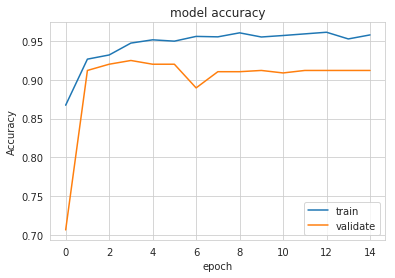

Epoch 1/20
135/135 [==============================] - 317s 2s/step - loss: 0.1351 - acc: 0.9467 - val_loss: 0.2320 - val_acc: 0.9247
Epoch 2/20
135/135 [==============================] - 299s 2s/step - loss: 0.1342 - acc: 0.9467 - val_loss: 0.2315 - val_acc: 0.9263
Epoch 3/20
135/135 [==============================] - 296s 2s/step - loss: 0.1384 - acc: 0.9469 - val_loss: 0.2324 - val_acc: 0.9199
Epoch 4/20
135/135 [==============================] - 297s 2s/step - loss: 0.1377 - acc: 0.9472 - val_loss: 0.2326 - val_acc: 0.9215
Epoch 5/20
134/135 [============================>.] - ETA: 1s - loss: 0.1323 - acc: 0.9457
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
135/135 [==============================] - 293s 2s/step - loss: 0.1324 - acc: 0.9457 - val_loss: 0.2345 - val_acc: 0.9215
Epoch 6/20
135/135 [==============================] - 296s 2s/step - loss: 0.1320 - acc: 0.9486 - val_loss: 0.2345 - val_acc: 0.9215
Epoch 7/20
135/135 [======================

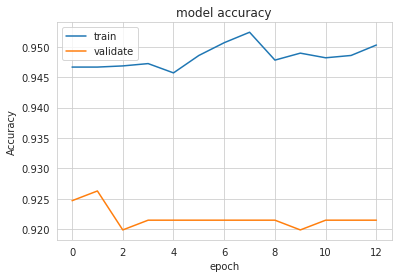

In [15]:
def train_model():
  hist = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=20,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             class_weight=class_w)

  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='best')
  plt.show()

train_model()

if keep_training:
  # Improving Generalization Performance by Switching from Adam to SGD
  # https://arxiv.org/abs/1712.07628
  model.compile(SGD(learning_rate=1e-5, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  train_model()

**4.0: Model Validation**    
The accuracy is assessed by a receiver operating characteristics area under the curve (**ROC AUC**) score, an F1 score, and a confusion matrix (True Positive/Negative vs False Positive/Negative).

(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

![AUC Figure](https://i.imgur.com/9qAEpH3.jpg)

> In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

https://www.sciencedirect.com/science/article/pii/S1556086415306043


**4.0: Predictions**    
First, how accurately can human radiologists diagnose pneumonia from an Xray?

In this study, published 2018 in the International Journal of Emergency Medicine:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5845910/ 62 patients were diagnosed with pneumonia by CT. Chest X-Rays had a diagnostic sensitivity for pneumonia (true positive rate) of 73% and a specificity (true negative rate) of 50%, corresponding to a calculated AUC (by trapezoidal rule) of 0.615.

In an article published in 2018 on swarm intelligence and pneumonia detection by CXR, human experts scored a 73% diagnostic accuracy, compared with 82% by radiologists: https://venturebeat.com/2018/09/10/unanimous-ai-achieves-22-more-accurate-pneumonia-diagnoses/

With these values in mind, now, let's see how our model compares using very low-resolution imagery, limited training samples, and a short training period on a single GPU with limited CPU memory. With greater resources, this model would be expected to acheive higher diagnostic accuracy.

In [16]:
vl_score = model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.94      0.85      0.90       234
   Pneumonia       0.92      0.97      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624

AUC:  0.9119658119658121


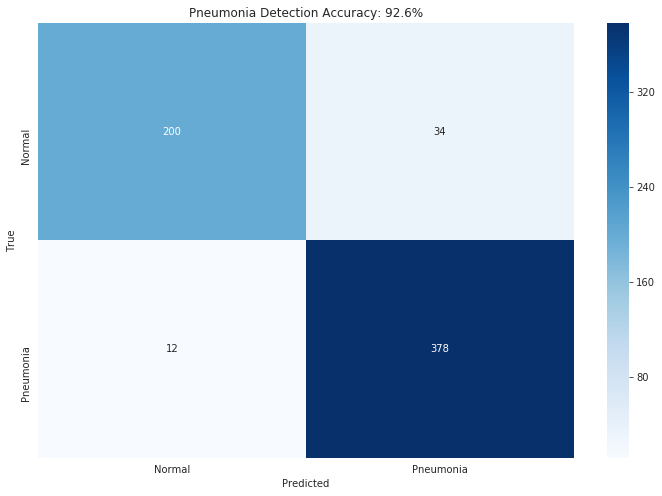

In [17]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [0]:
for l in range(len(model.layers)):
  if model.layers[l].name == 'attn_1':
    attn_1 = model.layers[l + 1]
  elif model.layers[l].name == 'attn_2':
    attn_2 = model.layers[l]
    break

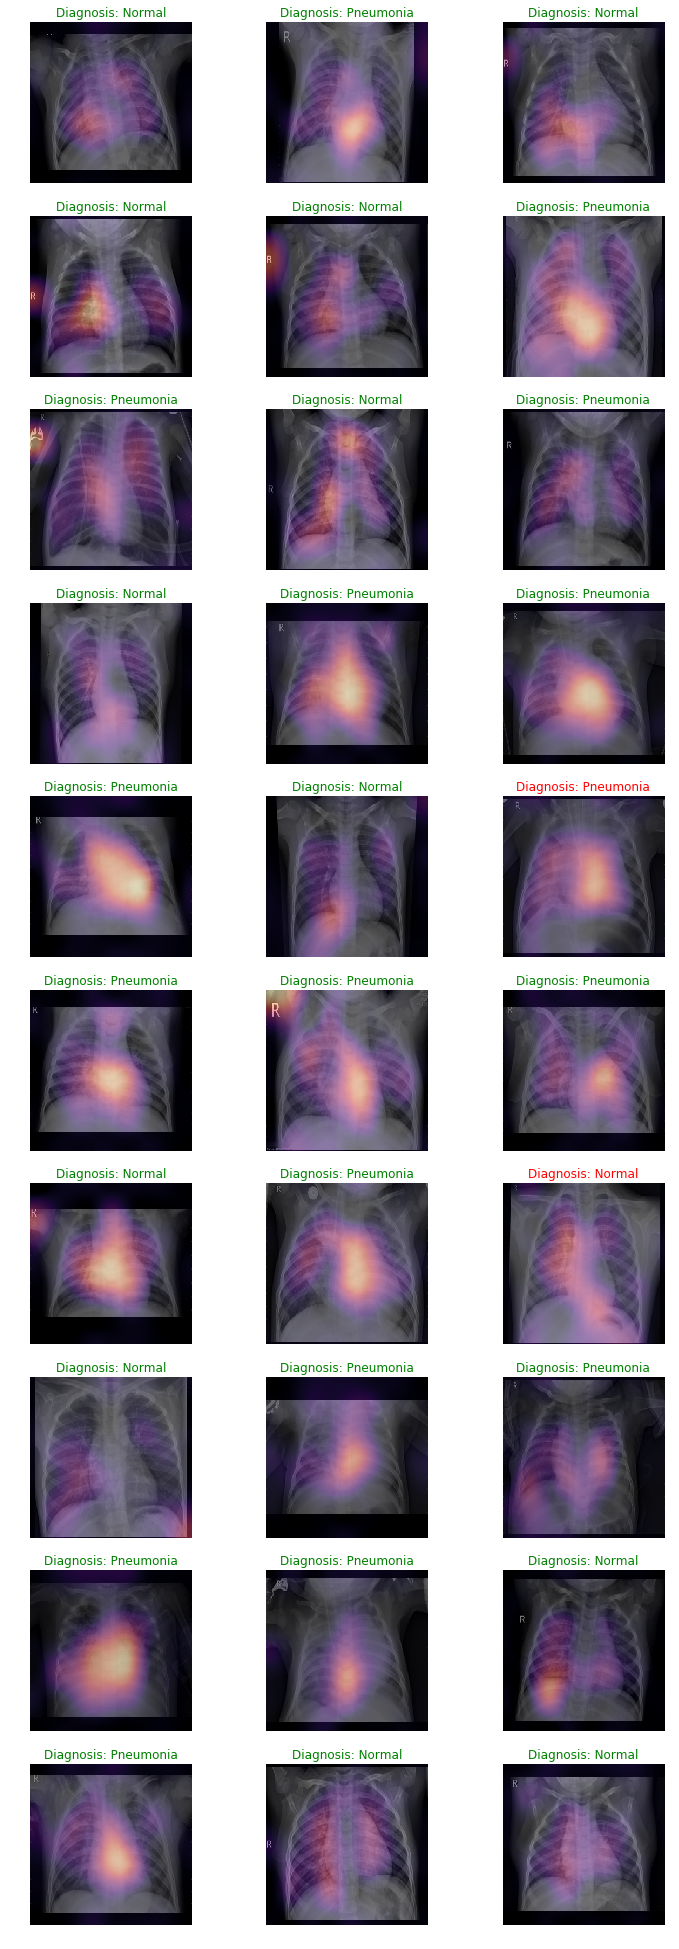

In [44]:
def func3(x, y):
    return (1 - x / 2 + x**5 + y**3) * np.exp(-(x**2 + y**2))

def plot_val_xrays(width=width//2, height=height//2,
                   rows=10, cols=3,
                   size_w=4, size_h=3.5):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  label_CM = {
    0: 'red',  # Incorrect diagnosis
    1: 'green' # Correct diagnosis
  }

  X_test_images, y_test_images = test_generator.next()

  attn_func_1 = K.function(inputs = [model.get_input_at(0), K.learning_phase()],
    outputs = [attn_1.get_output_at(0)]
  )

  attn_func_2 = K.function(inputs = [model.get_input_at(0), K.learning_phase()],
    outputs = [attn_2.get_output_at(0)]
  )

  for idx in range(0, rows*cols):
    i = random.randint(0, len(images_test))
    pred = np.round(vl_score[i][1])
    score = 1 if test_generator.classes[i] == pred else 0
    im_data = get_resized_image(images_test[i], 300, 225)

    im_data_xray = xray_process(im_data)
    attn_img_1 = attn_func_1(np.array([im_data_xray]))[0]
    attn_img_2 = attn_func_2(np.array([im_data_xray]))[0]
    attn_img = (attn_img_1 + attn_img_2) / 2
    attn_img = attn_img[0, :, :, 0]
        
    diagnosis_type = 'Pneumonia' if test_generator.classes[i] == 1 else 'Normal'
    diagnosis = 'Diagnosis: {}'.format(diagnosis_type)

    extent = 0, 1, 0, 1

    ax[idx//cols,idx%cols].imshow(im_data, cmap='gray_r', extent=extent)
    ax[idx//cols,idx%cols].imshow(attn_img, cmap='magma', vmin=0, vmax=1,
                                  extent=extent, alpha=0.5,
                                  interpolation='lanczos')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(diagnosis, color=label_CM[score])
  plt.show()

plot_val_xrays()